In [1]:
%%capture
import sys

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")

# Desactivar los warnings para evitar mensajes innecesarios durante la ejecución
import warnings

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from likelihood.models.deep import (
    AutoClassifier,
    GetInsights,
)  # Modelos de deep learning personalizados
from likelihood.tools import (
    OneHotEncoder,
    get_metrics,
    PerformanceMeasures,
)  # Herramientas auxiliares

warnings.filterwarnings("ignore")
import tensorflow as tf

import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10

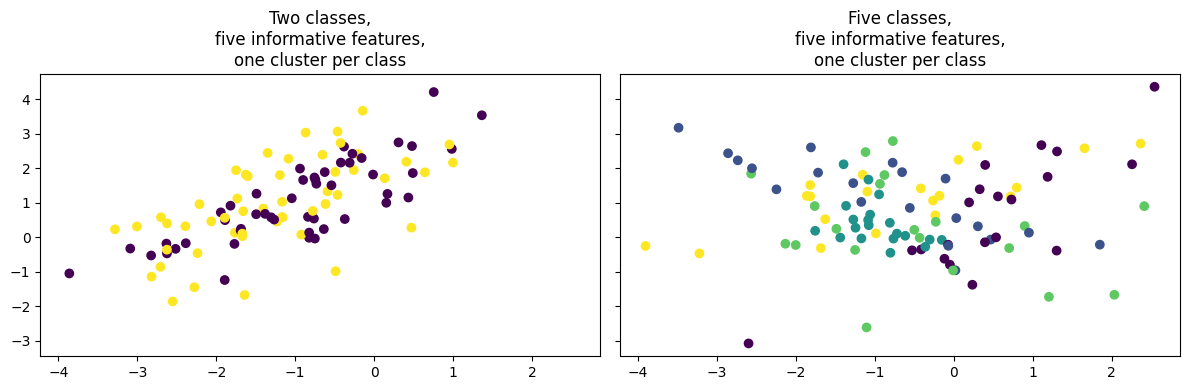

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=True)
titles = [
    "Two classes,\nfive informative features,\none cluster per class",
    "Five classes,\nfive informative features,\none cluster per class",
]
params = [
    {"n_informative": 5, "n_clusters_per_class": 1, "n_classes": 2},
    {"n_informative": 5, "n_clusters_per_class": 1, "n_classes": 5},
]

X_source, Y_source = make_classification(n_features=5, n_redundant=0, random_state=1, **params[0])
axs[0].scatter(X_source[:, 0], X_source[:, 1], c=Y_source)
axs[0].set_title(titles[0])

X_target, Y_target = make_classification(n_features=5, n_redundant=0, random_state=1, **params[1])
axs[1].scatter(X_target[:, 0], X_target[:, 1], c=Y_target)
axs[1].set_title(titles[1])

plt.tight_layout()
plt.show()

In [3]:
# OneHotEncoder convierte las etiquetas a formato one-hot encoding
y_encoder = OneHotEncoder()
Y_source_enc = y_encoder.encode(list(Y_source))
Y_target_enc = y_encoder.encode(list(Y_target))

X_source_train, X_source_test, Y_source_train, Y_source_test = train_test_split(
    X_source, Y_source_enc, test_size=0.2
)
X_target_train, X_target_test, Y_target_train, Y_target_test = train_test_split(
    X_target, Y_target_enc, test_size=0.2
)

In [4]:
# Create a source model
source_model = AutoClassifier(
    input_shape_parm=X_source.shape[1],
    num_classes=len(np.unique(Y_source)),
    units=16,
    activation="relu",
)

# Compilación del modelo: optimizador, función de pérdida y métricas
source_model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)

# Entrenar el modelo con los datos, usando 25 épocas y 20% de los datos para validación
source_model.fit(X_source_train, Y_source_train, epochs=25, validation_split=0.2, verbose=False)

# Hacer predicciones sobre el conjunto completo de datos
pred = source_model.predict(X_source)

# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame para su análisis
df = pd.DataFrame()
df["target"] = Y_source  # Columna de las etiquetas reales
df["prediction"] = pred_label  # Columna de las etiquetas predichas
df["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df["label_1"] = pred[:, 1]  # Probabilidad de la clase 1

# Calcular y mostrar las métricas del modelo comparando las etiquetas reales y las predicciones
get_metrics(df, "target", "prediction", verbose=True)

# Create a target model with different number of classes
target_model = AutoClassifier(
    input_shape_parm=X_target.shape[1],
    num_classes=len(np.unique(Y_target)),
    units=16,
    activation="selu",
    num_layers=3,
)

# Set the encoder and decoder from the source model to the target model
target_model.set_encoder_decoder(source_model)

# Freeze the encoder and decoder layers in the target model
target_model.freeze_encoder_decoder()

# Compilación del modelo: optimizador, función de pérdida y métricas
target_model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)

# Entrenar el modelo con los datos, usando 35 épocas y 20% de los datos para validación
target_model.fit(X_target_train, Y_target_train, epochs=35, validation_split=0.2, verbose=False)
# Hacer predicciones sobre el conjunto completo de datos
pred = target_model.predict(X_target)

# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

labels = list(np.unique(Y_target))

helper = PerformanceMeasures()
helper._summary_pred(Y_target, pred_label, labels)
_ = helper._f1_score(Y_target, pred_label, labels)
_ = helper.f_mean(Y_target, pred_label, labels)

4/4 [==============================] - 0s 0s/step
Accuracy: 92.00%
Precision: 97.78%
Recall: 86.27%
F1-Score: 91.67
Cohen's Kappa: 0.8403
4/4 [==============================] - 0s 0s/step
       --0-- | --1-- | --2-- | --3-- | --4--
--0--|     16  |      0  |      0  |      2  |      2 
--1--|      1  |     19  |      0  |      1  |      4 
--2--|      1  |      0  |     18  |      1  |      3 
--3--|      0  |      1  |      2  |     16  |      2 
--4--|      2  |      0  |      0  |      0  |      9 
F-measure of label 0 -> 0.8
F-measure of label 1 -> 0.8444
F-measure of label 2 -> 0.8372
F-measure of label 3 -> 0.7805
F-measure of label 4 -> 0.5806
Mean of F-measure -> 0.7685


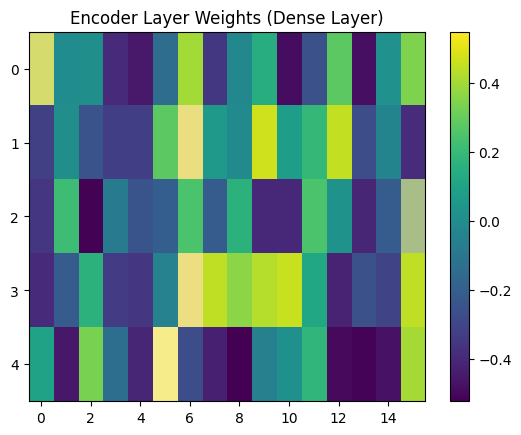

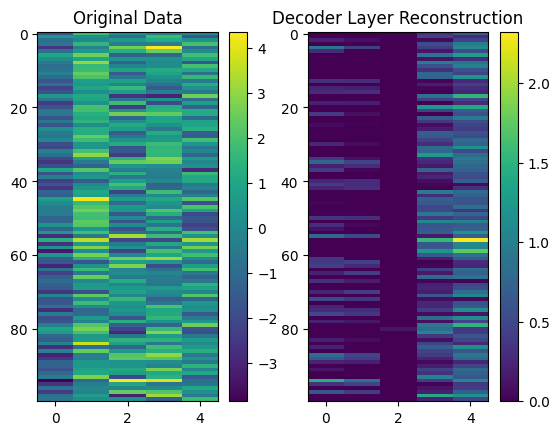

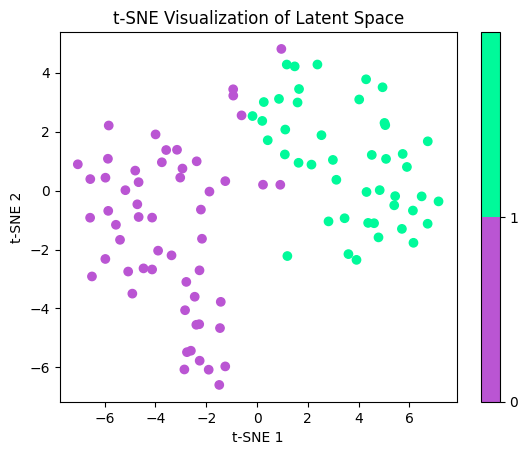

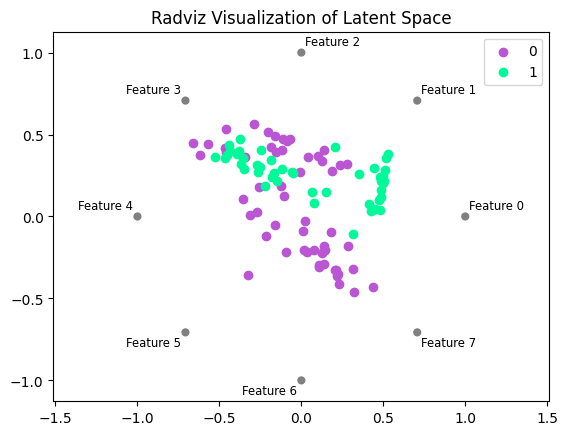

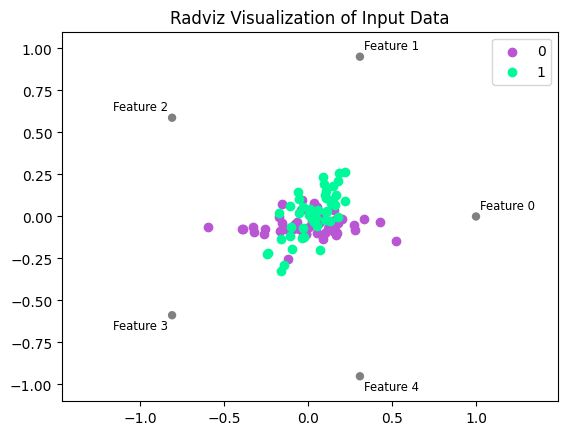

In [5]:
insights_source = GetInsights(source_model, X_source)
summary = insights_source.predictor_analyzer()

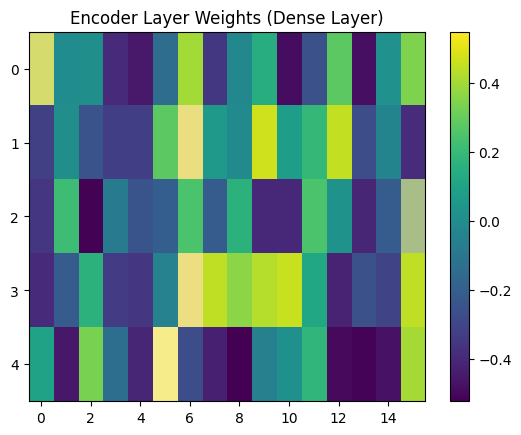

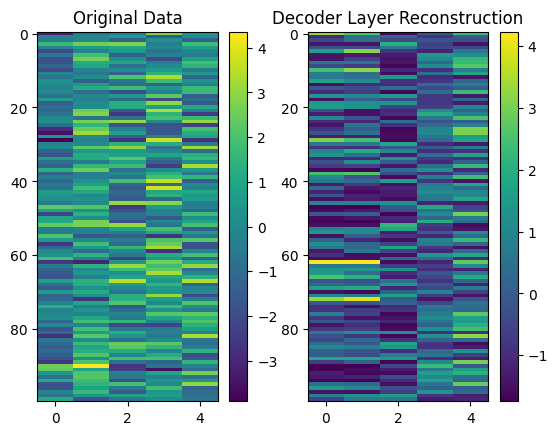

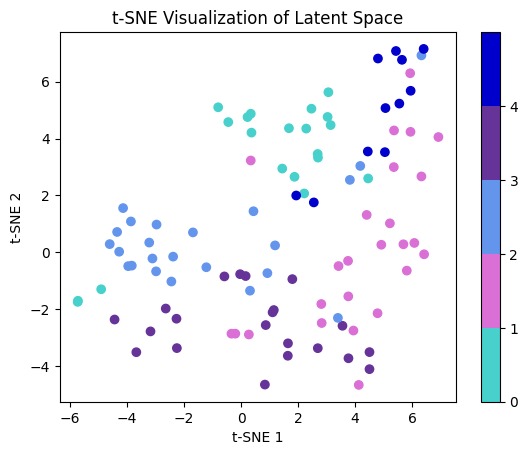

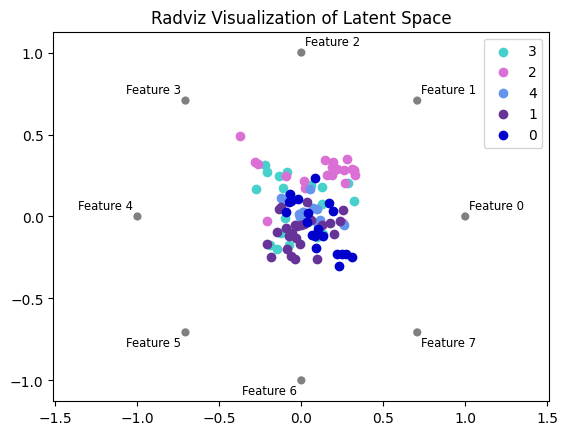

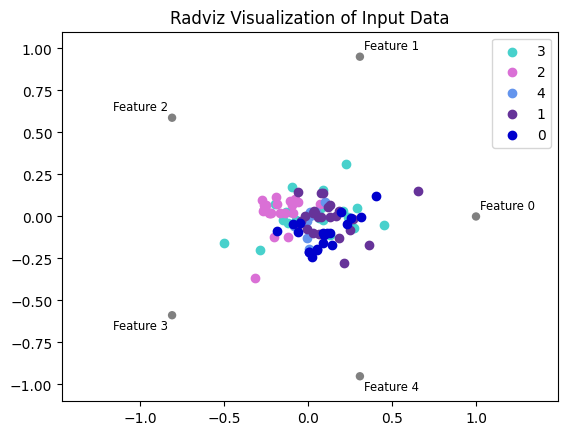

In [6]:
insights_target = GetInsights(target_model, X_target)
summary = insights_target.predictor_analyzer()

In [7]:
target_model.summary()

Model: "auto_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 232       
                                                                 
 sequential_1 (Sequential)   (None, 5)                 229       
                                                                 
 sequential (Sequential)     (None, 5)                 581       
                                                                 
Total params: 1042 (4.07 KB)
Trainable params: 581 (2.27 KB)
Non-trainable params: 461 (1.80 KB)
_________________________________________________________________


In [8]:
source_model.summary()

Model: "auto_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 232       
                                                                 
 sequential_1 (Sequential)   (None, 5)                 229       
                                                                 
 sequential_2 (Sequential)   (None, 2)                 28        
                                                                 
Total params: 489 (1.91 KB)
Trainable params: 489 (1.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Verificar si encoder y decoder de target son iguales a los de source
assert np.array_equal(
    source_model.encoder.get_weights()[0], target_model.encoder.get_weights()[0]
), "Encoder no es igual"
assert np.array_equal(
    source_model.decoder.get_weights()[0], target_model.decoder.get_weights()[0]
), "Decoder no es igual"